In [49]:
# Import the libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

from keras.utils.np_utils import to_categorical

import cv2

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# load dataset
image_arr = np.load('images.npy', allow_pickle=True)
name_df = pd.read_csv("Labels.csv")

In [3]:
#print shape of data
print(image_arr.shape)
print(name_df.shape)

(4750, 128, 128, 3)
(4750, 1)


Name: Small-flowered Cranesbill


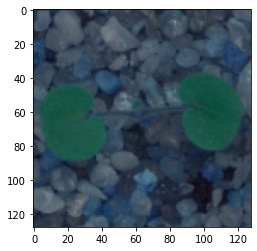

In [4]:
#Visualize the images in dataset.
i = 0
image = image_arr[i]
label = name_df.iloc[1].Label
print(f'Name: {label}')
plt.imshow(image);

### Data Pre-processing

In [5]:
#Normalization
image_arr = image_arr.astype('float32') # Conversion to float type from integer type.
image_arr /= 255.0 # Division by 255

In [6]:
#Gaussian Blurring
for i in range(image_arr.shape[0]):
    image_arr[i] = cv2.GaussianBlur(image_arr[i], (5,5), 0)

Name: Small-flowered Cranesbill


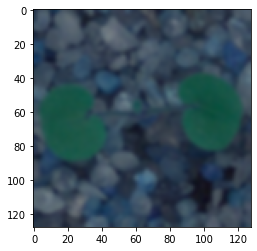

In [7]:
#Visualize the images in dataset post blurring
i = 0
image = image_arr[i]
label = name_df.iloc[1].Label
print(f'Name: {label}')
plt.imshow(image);

### Make data compatible

In [8]:
# Convert labels to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
name_arr = name_df.to_numpy()
enc = LabelBinarizer()
name_arr = enc.fit_transform(name_arr)

In [9]:
#Print the label for first row
print(name_arr[0])

[0 0 0 0 0 0 0 0 0 0 1 0]


In [10]:
#Split the dataset into training, testing, and validation set
test_idx = np.random.randint(low=0, high=4750, size=1425, dtype='I')
training_idx = [i for i in range(4750) if i not in test_idx]
validation_idx = test_idx[0:1426//2]
test_idx = test_idx[1426//2:]
validation_idx = np.array(validation_idx)
test_idx = np.array(test_idx)

X_train, X_test, X_validation = image_arr[training_idx,:], image_arr[test_idx,:], image_arr[validation_idx,:], 
y_train, y_test, y_validation = name_arr[training_idx,:], name_arr[test_idx,:], name_arr[validation_idx,:]

###### Reshape is not required the data is compatible

In [30]:
## Additional Data Augmentation

datagen = ImageDataGenerator( featurewise_center=False, 
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False, # 
rotation_range= 180, # randomly rotate images in the range (degrees, 0 to 180) 
zoom_range = 0.3, # Randomly zoom image 
width_shift_range=0.2, # randomly shift images horizontally (fraction of total width) 
height_shift_range=0.2, # randomly shift images vertically (fraction of total height) 
horizontal_flip=True, # randomly flip images 
vertical_flip=True) # randomly flip images

datagen.fit(X_train)
datagen.fit(X_test)
datagen.fit(X_validation)

In [12]:
#Check the shape of data

In [13]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(3501, 128, 128, 3)
(712, 128, 128, 3)
(713, 128, 128, 3)


In [14]:
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)

(3501, 12)
(712, 12)
(713, 12)


### Building CNN

In [15]:
# Define layers

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [22]:
#With the ReduceLROnPlateau function from Keras.callbacks,
#Reduce the LR by half if the accuracy is not improved after exceed patience (epochs).
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=6,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [17]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [18]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('plant_seedlings_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

Epoch 1/50
71/71 [==============================] - 177s 2s/step - loss: 0.9472 - accuracy: 0.6755 - val_loss: 2.0154 - val_accuracy: 0.2430

Epoch 00001: val_loss did not improve from 1.03634
Epoch 2/50
71/71 [==============================] - 178s 3s/step - loss: 0.9474 - accuracy: 0.6750 - val_loss: 1.5929 - val_accuracy: 0.4059

Epoch 00002: val_loss did not improve from 1.03634
Epoch 3/50
71/71 [==============================] - 178s 3s/step - loss: 0.9607 - accuracy: 0.6630 - val_loss: 1.5779 - val_accuracy: 0.3947

Epoch 00003: val_loss did not improve from 1.03634
Epoch 4/50
71/71 [==============================] - 178s 3s/step - loss: 0.9124 - accuracy: 0.6821 - val_loss: 1.4866 - val_accuracy: 0.4213

Epoch 00004: val_loss did not improve from 1.03634
Epoch 5/50
71/71 [==============================] - 179s 3s/step - loss: 0.8755 - accuracy: 0.6958 - val_loss: 1.7902 - val_accuracy: 0.3343

Epoch 00005: val_loss did not improve from 1.03634
Epoch 6/50
71/71 [=================

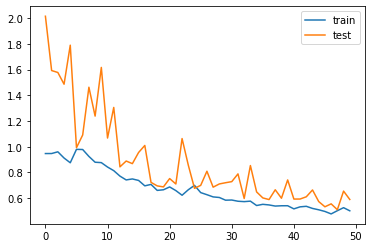

In [23]:
batch_size = 50
epochs = 50

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_validation, y_validation),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint, learning_rate_reduction])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

We can see the train accuracy is about 82%. This is a fairly good accuracy for the model. Next we will see what the accuracy is for the test and also the confusion matrix.

In [35]:
# Score trained model for test data
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 8s 331ms/step - loss: 0.5900 - accuracy: 0.8146
Test loss: 0.589993953704834
Test accuracy: 0.8146067261695862


In [37]:
# Score trained model for validation data
scores = model.evaluate(X_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 8s 332ms/step - loss: 0.5909 - accuracy: 0.8303
Test loss: 0.5908645987510681
Test accuracy: 0.8302945494651794


In [38]:
Y_pred = model.predict(X_validation)

In [39]:
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_validation,axis = 1)

In [52]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [51]:
species = name_df.Label.unique()

In [54]:
# Prep for the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[15  0  0  0  0  0 14  0  0  0  0  0]
 [ 0 41 10  0  0  0  0  0  2  0  3  0]
 [ 0  0 41  1  1  2  0  0  0  0  1  0]
 [ 0  0  0 79  0  1  0  0  6  3  7  0]
 [ 4  0  0  0 24  3  0  0  0  0  0  0]
 [ 0  1  1  0  0 75  0  0  0  0  0  1]
 [ 7  0  0  0  0  1 87  0  0  0  0  0]
 [ 0  1  0  0  1  0  1 26  1  0  3  4]
 [ 1  0  0  0  0  2  3  0 75  0  1  0]
 [ 0  0  0  0  0  1  0  0 14 11  2  1]
 [ 0  0  0  0  0  3  1  0  1  1 80  1]
 [ 0  0  0  0  2  5  0  0  2  0  0 38]]


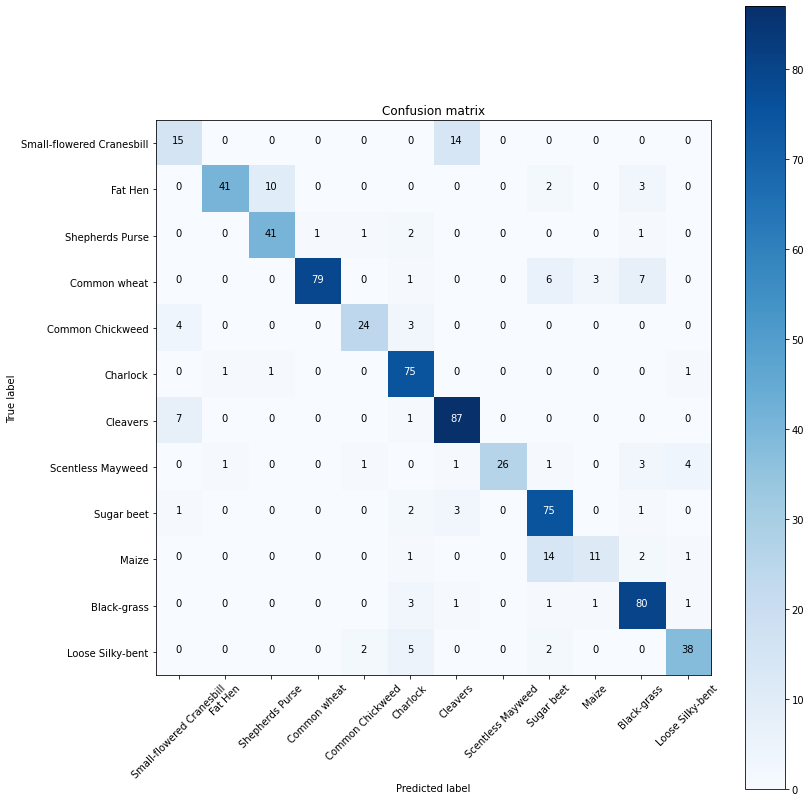

In [60]:
plt.figure(figsize=(12,12))
plot_confusion_matrix(confusion_mtx, classes=species,
                      title='Confusion matrix')